<a href="https://colab.research.google.com/github/adifatol/BIQA/blob/master/convNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [113]:
!ls blur

1600.BLUR.1.png		   log_seaside.BLUR.1.png
1600.BLUR.2.png		   log_seaside.BLUR.2.png
1600.BLUR.3.png		   log_seaside.BLUR.3.png
1600.BLUR.4.png		   log_seaside.BLUR.4.png
1600.BLUR.5.png		   log_seaside.BLUR.5.png
aerial_city.BLUR.1.png	   monument.BLUR.1.png
aerial_city.BLUR.2.png	   monument.BLUR.2.png
aerial_city.BLUR.3.png	   monument.BLUR.3.png
aerial_city.BLUR.4.png	   monument.BLUR.4.png
aerial_city.BLUR.5.png	   monument.BLUR.5.png
boston.BLUR.1.png	   native_american.BLUR.1.png
boston.BLUR.2.png	   native_american.BLUR.2.png
boston.BLUR.3.png	   native_american.BLUR.3.png
boston.BLUR.4.png	   native_american.BLUR.4.png
boston.BLUR.5.png	   native_american.BLUR.5.png
bridge.BLUR.1.png	   redwood.BLUR.1.png
bridge.BLUR.2.png	   redwood.BLUR.2.png
bridge.BLUR.3.png	   redwood.BLUR.3.png
bridge.BLUR.4.png	   redwood.BLUR.4.png
bridge.BLUR.5.png	   redwood.BLUR.5.png
butter_flower.BLUR.1.png   roping.BLUR.1.png
butter_flower.BLUR.2.png   roping.BLUR.2.png
butter_flower.BLUR.3.png 

# Upload Images

shows a dialog to upload new images

option to download the CSIQ Image Quality Database

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [115]:
!wget http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
!wget http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip
  
!unzip -n src_imgs.zip
!unzip -n dst_imgs.zip

--2019-05-10 16:08:49--  http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14455692 (14M) [application/zip]
Saving to: ‘src_imgs.zip.1’

src_imgs.zip.1      100%[===================>]  13.79M  6.92MB/s    in 2.0s    

2019-05-10 16:08:52 (6.92 MB/s) - ‘src_imgs.zip.1’ saved [14455692/14455692]

--2019-05-10 16:08:53--  http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374383009 (357M) [application/zip]
Saving to: ‘dst_imgs.zip.1’

dst_imgs.zip.1      100%[===================>] 357.04M  11.2MB/s    in 33s     

2019-0

# Load Images in colab

loads images of a certain SHAPE into runtime memory

In [116]:

import os

# List Image Names
# Parses each file name of format <NAME>.png
# TODO: support for other extensions?
def image_list( ext = '.png'):
  names = {}
  for f in [file for file in os.listdir() if file.endswith(ext)]:
    fname = os.path.splitext(f)[0]
    names[fname] = 1
  return list(names.keys())

img_list = image_list()
print('Images found: ', img_list)

Images found:  ['monument', 'veggies', 'trolley', 'butter_flower', 'woman', 'family', 'turtle', 'boston', 'lady_liberty', 'aerial_city', 'cactus', 'sunset_sparrow', 'elk', 'foxy', 'native_american', 'rushmore', 'roping', 'redwood', 'snow_leaves', 'shroom', 'log_seaside', '1600', 'bridge', 'couple', 'sunsetcolor', 'swarm', 'lake', 'geckos', 'fisher', 'child_swimming']


In [117]:

# Load the images
# Encode them into jpg

DISTORT = ['blur','contrast','fnoise', 'jpeg', 'jpeg2000']
DISTORT_EXT = ['BLUR','contrast','fnoise', 'JPEG', 'jpeg2000']
Q_LEVELS = ['1','2','3','4','5']
NR_IMG = 1

from random import randint
import numpy as np
import cv2

#TODO support for nItems = 'ALL'
#TODO support various loading order (randomize?)
def load_imgs(img_list, nItems):
  images = {}
  images['orig'] = []
  for dist in DISTORT:
    images[dist] = {}
    for qlvl in Q_LEVELS:
      images[dist][qlvl] = []

  for f in range(0,nItems):
    fname = img_list[f]
    original = fname+'.png'
    img_data = cv2.imread(original)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    images['orig'].append(img_data)
    for dist, d_ext in zip(DISTORT, DISTORT_EXT):
      for qlvl in Q_LEVELS:
        f_path = dist+'/'+fname+'.'+d_ext+'.'+qlvl+'.png'
        img_data = cv2.imread(f_path)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        images[dist][qlvl].append(img_data)
  return images

images = load_imgs(img_list, NR_IMG)

print("Nr of img:",len(images['orig']))


Nr of img: 1


In [0]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_all(arr_of_images, patch_estimator=False):
  columns = 5
  spacing = 14.75
  minorLocator = MultipleLocator(spacing)
  fig = plt.figure(figsize=(20,10))
  for i, image in enumerate(arr_of_images):
    ax = fig.add_subplot(len(images) / columns + 1, columns, i + 1)
    if patch_estimator:
      ax.yaxis.set_minor_locator(minorLocator)
      ax.xaxis.set_minor_locator(minorLocator)
      ax.grid(which = 'minor')
    plt.imshow(image)
  plt.show()


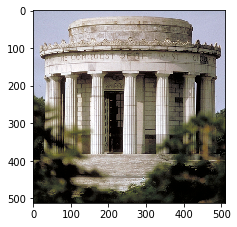

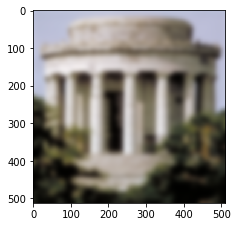

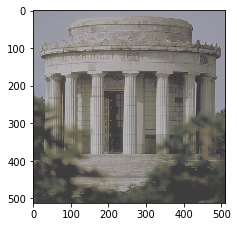

In [119]:
#Print some stats

rand_idx = randint(0, len(images['orig'])-NR_IMG)
plot_all(images['orig'][rand_idx:rand_idx+NR_IMG])
plot_all(images['blur']['5'][rand_idx:rand_idx+NR_IMG])
plot_all(images['contrast']['5'][rand_idx:rand_idx+NR_IMG])


# Score Images

apply the method suggested in [Learning without Human Scores for Blind Image Quality Assessment](https://www.cv-foundation.org/openaccess/content_cvpr_2013/papers/Xue_Learning_without_Human_2013_CVPR_paper.pdf)

## Extract Patches and calculate {SSIM} score

In [120]:
!pip install tqdm

In [132]:
from skimage.measure import compare_ssim
from skimage.util.shape import view_as_windows
from tqdm import tqdm

WH=28
WINDOW_SHAPE = (WH,WH,3)
PATCH_COUNT = 324 #TODO this should be automated somehow

def plot_patches(patches):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 1
  rows = 1
  for i in range(1, columns*rows +1):
      img = patches[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

def extract_patches(img):
  patches = np.squeeze(view_as_windows(img, WINDOW_SHAPE,step=WH))
  patches = np.reshape(patches,(-1,WH,WH,3))
  patches = np.sum(patches/3, axis=3, keepdims=True)
  return patches

dim_len, dim_dist, dim_q = len(images['orig']), len(DISTORT), len(Q_LEVELS);
test_len = dim_len

one_score = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
scores = [np.copy(one_score) for x in range(test_len)]
all_patches = []

for i in tqdm(range(len(images['orig'][:test_len]))):
  img = images['orig'][i]
  orig_patches = extract_patches(img)
  for idist, dist in enumerate(DISTORT):
    for iqlvl, qlvl in enumerate(Q_LEVELS):
      dist_img = images[dist][qlvl][i]
      distorted_patches = extract_patches(dist_img)
      local_scores = np.zeros(PATCH_COUNT)
      local_patches = []
      for j in range(PATCH_COUNT):
        orig_patch = orig_patches[j]
        dist_patch = distorted_patches[j]
        (score, diff) = compare_ssim(orig_patch, dist_patch, full=True, multichannel=True)
        local_scores[j] = score
        all_patches.append(dist_patch)
      scores[i][idist][iqlvl] = np.copy(local_scores)

#   plot_patches(orig_patches)
#   for patch in orig_patches:
#   (score, diff) = compare_ssim(dist_img, img, full=True, multichannel=True)
#   diff = (diff * 255).astype("uint8")
#   print("___")
#   print("SSIM: {}".format(score))


100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


## Calculate the C constant (![alt text](https://latex.codecogs.com/gif.latex?c%20%3D%20%5Cfrac%7B%5Csum%20_%7Bi%5Cepsilon%20%5COmega%7DS_%7Bi%7D%20%7D%7B10*%5Csum%20_%7Bi%5Cepsilon%20%5COmega_%7Bp%7D%7DS_%7Bi%7D%7D))

In [0]:
def the_C_constant(batch):
  all_sum = sum(batch)
  percentile10 = np.percentile(batch,10)
  omega_p_sum = sum([i for i in batch if i <= percentile10])
  c = all_sum / (10 * omega_p_sum)
  return c
# the_C_constant(scores[0][0][0])

## Histograms for scores

(1, 5, 5, 324)
3.1454207096564235
comparing for 0
(img-0 dist-1 qual-3)
[7.78556369 7.79211889 7.66305661 7.72877427 7.71289395 7.67582583
 7.64592973 7.63314412 7.64255153 7.74845307 7.72733101 7.70548612
 7.75698386 7.76287433 7.73931688 7.74958699 7.71086394 7.75402842
 7.80740277 7.74282584 7.79597999 7.63437521 7.6812588  7.6933149
 7.6469199  7.69600259 7.6990248  7.74686162 7.81393257 7.81798617
 7.78182354 7.80426138 7.706593   7.77260573 7.76084643 7.69570775
 7.72417898 7.71842134 7.71506436 7.68167904 7.61624404 7.63779637
 7.63282427 7.66505071 7.6983323  7.78337867 7.76225677 7.80473483
 7.82187591 7.71936703 7.56456725 7.68197325 7.71819155 7.71429354
 7.64348515 7.6564502  7.64624912 7.7043589  7.68765847 7.67489339
 7.70170606 7.73045726 7.730492   7.72264062 7.75882857 7.78077702
 7.76966984 7.78532821 7.79295927 7.47840567 7.51367917 7.67202036
 7.73905511 7.69092876 7.69586953 7.63377475 7.64361605 7.63480899
 7.62444985 7.65022783 7.71170171 7.77702365 7.75720942 7.

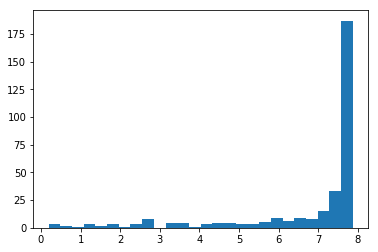

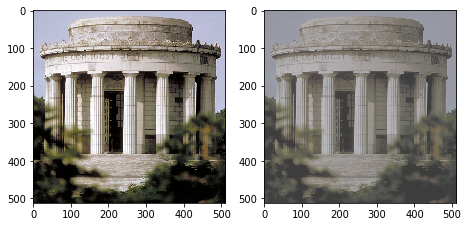

In [123]:
#Random scores visualisations

from mpl_toolkits.mplot3d import Axes3D

def histogram(img_idx, img_dist, img_qual):
  print("comparing for {}".format(img_idx))
  print("(img-{} dist-{} qual-{})".format(img_idx, img_dist, img_qual))
  print(scores[img_idx][img_dist][img_qual])
  plt.hist(scores[img_idx][img_dist][img_qual], bins='auto')
  plt.show()

ri = randint(0,dim_len-1)
rd = randint(0,dim_dist-1)
rq = randint(0,dim_q-1)

print(np.array(scores).shape)

for i in range(ri,ri+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      c = the_C_constant(scores[i][d][q])
      print(c)
      histogram(ri,rd,rq)
      plot_all([images['orig'][i],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])


## Normalize scores

In [0]:
norm_scores = np.copy(scores)
all_scores = []
for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
      c = the_C_constant(scores[i][d][q])
      norm_scores[i][d][q][:] = [x / c for x in norm_scores[i][d][q]]
      all_scores.extend(norm_scores[i][d][q])


(img-0 dist-contrast qual-4)


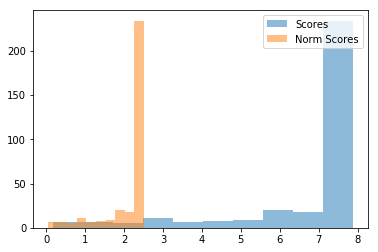

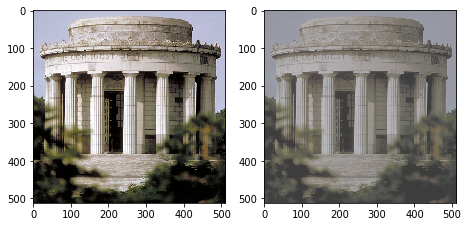

In [125]:
print("(img-{} dist-{} qual-{})".format(ri, DISTORT[rd], Q_LEVELS[rq]))

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.legend(loc='upper right')
plt.show()

plot_all([images['orig'][ri],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])

## Score QAC - Quality Aware Clusters

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
(1, 5, 5, 324)
(1, 5, 5, 324)


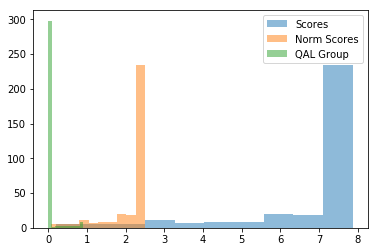

In [126]:
# Define The Score Levels used in QAC

L = 10
Gl = list(range(1,L+1))
Gl[:] = [x / L for x in Gl]


one_group = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
G = [np.copy(one_group) for x in range(dim_len)]

print(Gl)
print(np.array(G).shape)
print(np.array(norm_scores).shape)

# for i in range(0,dim_len):
#   for d in range(0,dim_dist):
#     for q in range(0,dim_q):
for i in range(ri,i+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      for p,score in enumerate(norm_scores[i][d][q]):
        for score_l in Gl:
          if score <= score_l:
            G[i][d][q][p] = score_l
            break

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.hist(G[ri][rd][rq], alpha=0.5, label='QAL Group')
plt.legend(loc='upper right')
plt.show()

## Convolutional network with Keras and TPUs

### Prepare the training data

In [127]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_patches), np.array(all_scores), test_size=0.33, shuffle= True)

print(np.array(all_patches).shape)
print(np.array(all_scores).shape)

print(np.array(x_train).shape)
print(np.array(y_train).shape)

print(np.array(x_valid).shape)
print(np.array(y_valid).shape)
#Sigmas: [0.2, 2.0, 4.0]

# def all_filtered_patches(all_patches, sigma):
#   all_filtered = []
#   for i in tqdm(range(len(all_patches))):
#     patch = all_patches[i]
#     gray_patch = color.rgb2gray(patch)
#     filtered = dog(gray_patch, sigma)
#     all_filtered.append(filtered)
#   return all_filtered
# filtered_02 = all_filtered_patches(all_patches, 0.2)
# filtered_20 = all_filtered_patches(all_patches, 2.0)
# filtered_40 = all_filtered_patches(all_patches, 4.0)
    
  

(8100, 28, 28, 1)
(8100,)
(5427, 28, 28, 1)
(5427,)
(2673, 28, 28, 1)
(2673,)


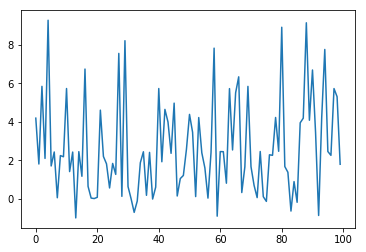

In [128]:
plt.plot(y_train[:100])

### Declare the model

In [129]:
# The model, based on https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=Zo-Yk6LFGfSf

import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1_12 (B (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_v1_13 (B (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 128)         0         
__________

In [130]:
import os
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
    

tpu_model.fit_generator(
    train_gen(1024),
    epochs=1,
    steps_per_epoch=1000,
    validation_data=(x_valid, y_valid),
)

INFO:tensorflow:Querying Tensorflow master (grpc://10.121.26.234:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 12944577981448582848)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10711799350594237212)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2038317187287438735)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17238597238074637518)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5727907788211861149)
INFO:tensorflow:*** Available Device: _DeviceAttribute

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(2, 28, 28, 1), dtype=tf.float32, name='batch_normalization_v1_12_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_v1_12_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 11.385512828826904 secs


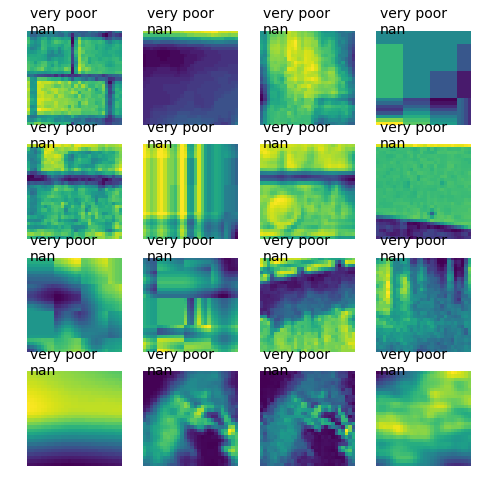

In [131]:
LABEL_NAMES = ['very poor', 'poor', 'better', 'ok', 'very ok', 'super ok', 'good', 'very good', 'super good', 'extraordinary']


cpu_model = tpu_model.sync_to_cpu()

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.5f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  
start_from = randint(0, x_valid.shape[0]-16)
plot_predictions(np.squeeze(x_valid[start_from:start_from+16]), 
                 tpu_model.predict(x_valid[start_from:start_from+16]))